In [1]:
import json
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
import pandas as pd
import pickle

data_dir = "/mnt/hdd/ai_n_slo/gazet_dataset_depth/dataset"
destination_directory = "/mnt/hdd/ai_n_slo/gazet-depth-cropped"

In [2]:
!ls "/mnt/hdd/ai_n_slo"

face_emotion_recognition  gazet-data-original  gazet_dataset_depth.zip	misc
gazet-data-cropped	  gazet_dataset_depth  gazet-depth-cropped


In [3]:
# load metadata and index
with open(os.path.join(data_dir, 'metadata.json'), 'r') as f:
    meta_index = json.load(f)

In [4]:
meta_index[1000]

{'task_id': '12b5d912-1ff9-45a2-9654-b607fe8003d4',
 'step': 'step_0.jpeg',
 'relative_x': 0.0,
 'relative_y': 0.0,
 'screen_size_x': 1366,
 'screen_size_y': 768,
 'screen_size_cm_x': 34.1096227997412,
 'screen_size_cm_y': 19.17729890937133,
 'diagonal_cm': 39.131,
 'type': 'gaze_on_fixed_point',
 'is_notebook': True,
 'eyes_left_left': [377, 247],
 'eyes_left_right': [339, 248],
 'eyes_right_left': [293, 246],
 'eyes_right_right': [255, 242],
 'split': 'train'}

In [5]:
def load_depth(meta):
    '''
    Read depth
    '''
    
    depth_path = os.path.join(data_dir, 'depth', meta['task_id'], meta['step'][:-4]+"pkl")

    with open(depth_path, "rb") as f:
        d = pickle.load(f)
        
    return d

In [6]:
def crop_depth(d, bbox, eyes):
    '''
    Crop bbox from depth
    '''
    
    x, y, w, h = bbox
    x-=d["bbox"][0]
    y-=d["bbox"][1]
    

    eye_points = [
        d["depth"][
        eye_point[1] - d["bbox"][1],
        eye_point[0] - d["bbox"][0]
    ]
        for eye_point in eyes
    ]

    return d["depth"][y:y+h, x:x+w], eye_points

# create bounding box of eyes field and crop it from image to further train
def crop_eyes(d, meta):
    '''
    Create bounding box from eyes points and crop eyes field from image to further train and inference
    '''
    left_left_point, left_right_point, right_left_point, right_right_point = [
        meta['eyes_left_left'],
        meta['eyes_left_right'],
        meta['eyes_right_left'],
        meta['eyes_right_right']
    ]
    left_med = [(left_left_point[0] + left_right_point[0]) / 2, (left_left_point[1] + left_right_point[1]) / 2]
    right_med = [(right_left_point[0] + right_right_point[0]) / 2, (right_left_point[1] + right_right_point[1]) / 2]

    left_dist = np.sqrt(
        (left_left_point[0] - left_right_point[0]) ** 2 + (left_left_point[1] - left_right_point[1]) ** 2
    )
    right_dist = np.sqrt(
        (right_left_point[0] - right_right_point[0]) ** 2 + (right_left_point[1] - right_right_point[1]) ** 2
    )
    mean_dist = (left_dist + right_dist) / 2

    cropped_depth, eye_points = crop_depth(
        d,
        bbox=[
            int(min(left_med[0] - mean_dist, right_med[0] - mean_dist)),
            int(min(left_med[1] - mean_dist, right_med[1] - mean_dist)),
            int(2 * mean_dist + abs(left_med[0] - right_med[0])),
            int(2 * mean_dist + abs(left_med[1] - right_med[1])),
        ],
        eyes = [left_left_point, left_right_point, right_left_point, right_right_point]
    )
    return cropped_depth, eye_points

In [7]:
import datetime

eof_errors = []
size_errors = []
EYE_DEPTH = []

for i_, meta in enumerate(meta_index):
    try:
        d = load_depth(meta)

        if d["depth"].shape != (d["bbox"][-1], d["bbox"][-2]):
            size_errors.append(meta)
        else:
            depth_crop, eye_points = crop_eyes(d, meta)
            meta["eye_depth"] = eye_points
            EYE_DEPTH.append(meta)
            
            task_dir = os.path.join(destination_directory, 'depth', meta['task_id'])
            if not os.path.exists(task_dir):
                os.makedirs(task_dir)
        
            with open(os.path.join(destination_directory, 'depth', meta['task_id'], meta['step'][:-4]+"pickle"), 'wb') as handle:
                pickle.dump(depth_crop, handle, protocol=pickle.HIGHEST_PROTOCOL)

    except EOFError:
        eof_errors.append(meta)

    if i_%10_000 == 0:
        print(f"[{i_}/{len(meta_index)}]")
        print(datetime.datetime.now().time())
        print(len(eof_errors), len(size_errors))

with open(os.path.join(destination_directory, "eye_depth.pickle"), 'wb') as handle:
    pickle.dump(EYE_DEPTH, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.path.join(destination_directory, "eof_errors.pickle"), 'wb') as handle:
    pickle.dump(eof_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(os.path.join(destination_directory, "size_errors.pickle"), 'wb') as handle:
    pickle.dump(size_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(len(eof_errors), " eof_errors")
print(len(size_errors), " size_errors")


[0/144275]
18:55:11.671579
0 0
[10000/144275]
18:55:21.815295
0 3
[20000/144275]
18:55:32.741262
0 7
[30000/144275]
18:55:45.046912
0 7
[40000/144275]
18:55:56.349289
0 8
[50000/144275]
18:56:08.163448
0 8
[60000/144275]
18:56:20.609374
0 8
[70000/144275]
18:56:32.647759
0 8
[80000/144275]
18:56:45.290400
0 8
[90000/144275]
18:56:56.855257
0 8
[100000/144275]
18:57:09.232974
0 8
[110000/144275]
18:57:22.054809
29 9
[120000/144275]
18:57:33.512195
29 9
[130000/144275]
18:57:44.135497
29 9
[140000/144275]
18:57:56.684136
56 9
56  eof_errors
11  size_errors


In [8]:
d["depth"].shape != (d["bbox"][-1], d["bbox"][-2])

True

In [7]:
size_errors

[{'task_id': '9ba4ce85-a92f-4f27-8109-df4ef6790742',
  'step': 'step_0.jpeg',
  'relative_x': 0.0,
  'relative_y': 0.0,
  'screen_size_x': 1920,
  'screen_size_y': 1080,
  'screen_size_cm_x': 46.50814223650307,
  'screen_size_cm_y': 26.16083000803297,
  'diagonal_cm': 53.361,
  'type': 'gaze_on_fixed_point',
  'is_notebook': False,
  'eyes_left_left': [613, 203],
  'eyes_left_right': [578, 208],
  'eyes_right_left': [532, 209],
  'eyes_right_right': [490, 207],
  'split': 'train'},
 {'task_id': 'c97fc82c-cc93-4940-b1a0-e294a227a0ac',
  'step': 'step_0.jpeg',
  'relative_x': 0.5,
  'relative_y': 0.0,
  'screen_size_x': 1366,
  'screen_size_y': 768,
  'screen_size_cm_x': 29.458350221493287,
  'screen_size_cm_y': 16.562234970795647,
  'diagonal_cm': 33.795,
  'type': 'gaze_on_fixed_point',
  'is_notebook': True,
  'eyes_left_left': [1265, 571],
  'eyes_left_right': [1177, 561],
  'eyes_right_left': [1055, 539],
  'eyes_right_right': [958, 518],
  'split': 'train'},
 {'task_id': '8ebe2562-

In [28]:
import datetime

focal_length = []
for i_, meta in enumerate(meta_index):
    try:
        d = load_depth(meta)

        if d["depth"].shape != (d["bbox"][-1], d["bbox"][-2]):
            size_errors.append(meta)
        else:
            meta["focallength_px"] = d["focallength_px"]
            focal_length.append(meta)
    except:
        pass

    if i_%10_000 == 0:
        print(f"[{i_}/{len(meta_index)}]")
        print(datetime.datetime.now().time())

[0/144275]
08:32:38.301934
[10000/144275]
08:32:38.881591
[20000/144275]
08:32:39.447726
[30000/144275]
08:32:40.029987
[40000/144275]
08:32:40.592882
[50000/144275]
08:32:41.158753
[60000/144275]
08:32:41.723512
[70000/144275]
08:32:42.314647
[80000/144275]
08:32:42.919900
[90000/144275]
08:32:43.472481
[100000/144275]
08:32:44.082029
[110000/144275]
08:32:44.650642
[120000/144275]
08:32:45.214474
[130000/144275]
08:32:45.756639
[140000/144275]
08:32:46.287999


In [29]:
pd.DataFrame(focal_length).to_csv(os.path.join(destination_directory, "focal_length.csv"), sep="\t")

In [33]:
!ls /mnt/hdd/ai_n_slo/gazet-depth-cropped

depth  eof_errors.pickle  focal_length.csv  size_errors.pickle


In [31]:
!head /mnt/hdd/ai_n_slo/gazet-depth-cropped/focal_length.csv

	task_id	step	relative_x	relative_y	screen_size_x	screen_size_y	screen_size_cm_x	screen_size_cm_y	diagonal_cm	type	is_notebook	eyes_left_left	eyes_left_right	eyes_right_left	eyes_right_right	split	focallength_px
0	8f0ba296-96d9-4ff0-8de9-13cc0e2ae671	step_0.jpeg	0.0	0.0	1280	1024	33.73118996151058	26.98495196920847	43.197	gaze_on_fixed_point	False	[632, 688]	[543, 698]	[434, 711]	[347, 722]	train	1596.9104
1	8f0ba296-96d9-4ff0-8de9-13cc0e2ae671	step_1.jpeg	1.0	0.0	1280	1024	33.73118996151058	26.98495196920847	43.197	gaze_on_fixed_point	False	[574, 679]	[494, 684]	[395, 692]	[332, 699]	train	1642.5161
2	8f0ba296-96d9-4ff0-8de9-13cc0e2ae671	step_2.jpeg	0.0	1.0	1280	1024	33.73118996151058	26.98495196920847	43.197	gaze_on_fixed_point	False	[669, 724]	[582, 733]	[475, 741]	[390, 746]	train	1613.3568
3	8f0ba296-96d9-4ff0-8de9-13cc0e2ae671	step_3.jpeg	1.0	1.0	1280	1024	33.73118996151058	26.98495196920847	43.197	gaze_on_fixed_point	False	[592, 731]	[511, 739]	[416, 745]	[352, 747]	train	1640.2

In [32]:
pd.DataFrame(focal_length).shape

(144208, 17)

In [9]:
d

{'depth': array([[0.4998232 , 0.49911773, 0.49797028, ..., 0.6576812 , 0.71187395,
         0.76844734],
        [0.49978957, 0.49887827, 0.49797028, ..., 0.6893169 , 0.7470079 ,
         0.82086945],
        [0.49978957, 0.49909374, 0.49797028, ..., 0.7044264 , 0.77925915,
         0.90926737],
        ...,
        [0.50562805, 0.50493556, 0.5037612 , ..., 0.74960035, 0.769764  ,
         0.7608852 ],
        [0.5061154 , 0.50493556, 0.5037612 , ..., 0.5774942 , 0.5864756 ,
         0.5960414 ],
        [0.5061154 , 0.50493556, 0.50420094, ..., 0.5353565 , 0.54070234,
         0.55182356]], shape=(95, 184), dtype=float32),
 'focallength_px': array(649.78894, dtype=float32),
 'bbox': [456, 158, 193, 95],
 'original_size': (480, 640)}

In [10]:
d["depth"].shape == (d["bbox"][-1], d["bbox"][-2])

True

In [33]:
meta_index[i_+70]

{'task_id': '0eccf74d-9477-4a7f-923a-a0a51bfdf8fe',
 'step': 'step_7.jpeg',
 'relative_x': 0.2627991221890001,
 'relative_y': 0.1255665041079285,
 'screen_size_x': 1366,
 'screen_size_y': 768,
 'screen_size_cm_x': 34.1096227997412,
 'screen_size_cm_y': 19.17729890937133,
 'diagonal_cm': 39.131,
 'type': 'gaze_on_random_point',
 'is_notebook': True,
 'eyes_left_left': [426, 223],
 'eyes_left_right': [379, 222],
 'eyes_right_left': [320, 220],
 'eyes_right_right': [274, 218],
 'split': 'train'}

In [6]:
meta

{'task_id': '5fef5e1d-b040-44ad-ba14-0f11fbd2273e',
 'step': 'step_15.jpeg',
 'relative_x': 0.4972350801379602,
 'relative_y': 0.89974672415145,
 'screen_size_x': 1920,
 'screen_size_y': 1080,
 'screen_size_cm_x': 34.10562234322074,
 'screen_size_cm_y': 19.18441256806167,
 'diagonal_cm': 39.131,
 'type': 'gaze_on_random_point',
 'is_notebook': True,
 'eyes_left_left': [745, 350],
 'eyes_left_right': [686, 351],
 'eyes_right_left': [612, 352],
 'eyes_right_right': [551, 351],
 'split': 'train'}

In [1]:
!ls /mnt/hdd/ai_n_slo/gazet_dataset_depth/dataset/depth/a6e4adf3-a66f-4dc0-a0a1-9658b8770bef/

step_0.pkl   step_13.pkl  step_17.pkl  step_20.pkl  step_5.pkl	step_9.pkl
step_10.pkl  step_14.pkl  step_18.pkl  step_2.pkl   step_6.pkl
step_11.pkl  step_15.pkl  step_19.pkl  step_3.pkl   step_7.pkl
step_12.pkl  step_16.pkl  step_1.pkl   step_4.pkl   step_8.pkl


In [1]:
!ls /mnt/hdd/ai_n_slo/gazet_dataset_depth/dataset/depth/a6e4adf3-a66f-4dc0-a0a1-9658b8770bef/

step_0.pkl   step_13.pkl  step_17.pkl  step_20.pkl  step_5.pkl	step_9.pkl
step_10.pkl  step_14.pkl  step_18.pkl  step_2.pkl   step_6.pkl
step_11.pkl  step_15.pkl  step_19.pkl  step_3.pkl   step_7.pkl
step_12.pkl  step_16.pkl  step_1.pkl   step_4.pkl   step_8.pkl


In [3]:
with open("/mnt/hdd/ai_n_slo/gazet_dataset_depth/dataset/depth/a6e4adf3-a66f-4dc0-a0a1-9658b8770bef/step_0.pkl", "rb") as f:
    d = pickle.load(f)
d

{'depth': array([[0.5995622 , 0.59869045, 0.5980674 , ..., 0.6022717 , 0.6029035 ,
         0.60366   ],
        [0.5995622 , 0.59869045, 0.5980674 , ..., 0.6022717 , 0.6029035 ,
         0.6035366 ],
        [0.5997643 , 0.5990154 , 0.5982166 , ..., 0.6022516 , 0.6029035 ,
         0.6035366 ],
        ...,
        [0.65097845, 0.6498103 , 0.6486934 , ..., 0.5943149 , 0.5954334 ,
         0.5967502 ],
        [0.65041953, 0.6489673 , 0.6479105 , ..., 0.5947587 , 0.5957309 ,
         0.59717596],
        [0.64976406, 0.648559  , 0.6474392 , ..., 0.5950616 , 0.59629637,
         0.5975363 ]], shape=(214, 421), dtype=float32),
 'focallength_px': array(1724.191, dtype=float32),
 'bbox': [634, 330, 421, 214],
 'original_size': (1080, 1600)}

In [10]:
import torch

In [12]:
torch.tensor(np.ones((5,5))*d['focallength_px'])

tensor([[1724.1910, 1724.1910, 1724.1910, 1724.1910, 1724.1910],
        [1724.1910, 1724.1910, 1724.1910, 1724.1910, 1724.1910],
        [1724.1910, 1724.1910, 1724.1910, 1724.1910, 1724.1910],
        [1724.1910, 1724.1910, 1724.1910, 1724.1910, 1724.1910],
        [1724.1910, 1724.1910, 1724.1910, 1724.1910, 1724.1910]],
       dtype=torch.float64)

In [16]:
d["depth"].ravel()

array([0.58723253, 0.5866438 , 0.5860563 , ..., 0.8273061 , 0.8273061 ,
       0.8273061 ], shape=(86320,), dtype=float32)

(array([ 622.,  404.,  412.,  504.,  401.,  410.,  417.,  497., 4094.,
        3751., 3731., 3824., 3572., 2421., 2350., 2507., 2963., 3035.,
        2812., 3092., 2599., 3356., 4378., 4420., 2646., 2029., 1845.,
        1635., 1470., 1407., 1328., 1228., 1118., 1073., 1016.,  990.,
         888.,  828.,  819.,  804.,  761.,  763.,  734.,  676.,  677.,
         689.,  645.,  594.,  581.,  576.,  536.,  462.,  452.,  434.,
         396.,  347.,  348.,  332.,  318.,  238.,  217.,  191.,  181.,
         114.,  135.,   58.,   92.,   74.,   64.,   22.,   88.,   56.,
          52.,   83.,   20.,   28.,   26.,   36.,   17.,   22.,   11.,
          10.,   10.,    7.,    7.,    8.,    9.,    6.,    9.,   10.,
          11.,    6.,   11.,   16.,   10.,   15.,   21.,   24.,   29.,
          33.]),
 array([0.53359878, 0.53478748, 0.53597617, 0.53716493, 0.53835362,
        0.53954232, 0.54073101, 0.54191971, 0.5431084 , 0.54429716,
        0.54548585, 0.54667455, 0.54786325, 0.54905194, 0.55024064

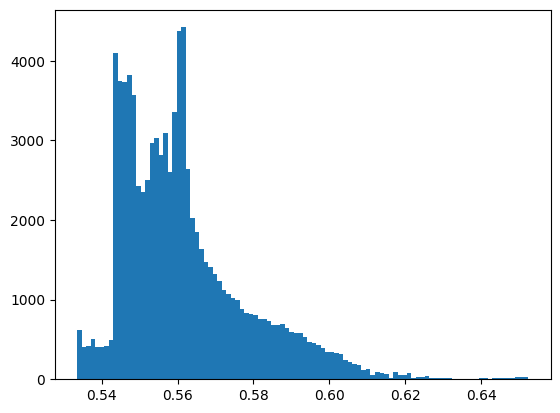

In [20]:
plt.hist(d["depth"].ravel(), bins=100)

In [34]:
!du -la /mnt/hdd/ai_n_slo/gazet_dataset_depth/dataset/depth/0eccf74d-9477-4a7f-923a-a0a51bfdf8fe/

104	/mnt/hdd/ai_n_slo/gazet_dataset_depth/dataset/depth/0eccf74d-9477-4a7f-923a-a0a51bfdf8fe/step_14.pkl
108	/mnt/hdd/ai_n_slo/gazet_dataset_depth/dataset/depth/0eccf74d-9477-4a7f-923a-a0a51bfdf8fe/step_7.pkl
112	/mnt/hdd/ai_n_slo/gazet_dataset_depth/dataset/depth/0eccf74d-9477-4a7f-923a-a0a51bfdf8fe/step_11.pkl
108	/mnt/hdd/ai_n_slo/gazet_dataset_depth/dataset/depth/0eccf74d-9477-4a7f-923a-a0a51bfdf8fe/step_15.pkl
116	/mnt/hdd/ai_n_slo/gazet_dataset_depth/dataset/depth/0eccf74d-9477-4a7f-923a-a0a51bfdf8fe/step_4.pkl
108	/mnt/hdd/ai_n_slo/gazet_dataset_depth/dataset/depth/0eccf74d-9477-4a7f-923a-a0a51bfdf8fe/step_0.pkl
108	/mnt/hdd/ai_n_slo/gazet_dataset_depth/dataset/depth/0eccf74d-9477-4a7f-923a-a0a51bfdf8fe/step_12.pkl
104	/mnt/hdd/ai_n_slo/gazet_dataset_depth/dataset/depth/0eccf74d-9477-4a7f-923a-a0a51bfdf8fe/step_22.pkl
104	/mnt/hdd/ai_n_slo/gazet_dataset_depth/dataset/depth/0eccf74d-9477-4a7f-923a-a0a51bfdf8fe/step_25.pkl
100	/mnt/hdd/ai_n_slo/gazet_dataset_depth/dataset/depth/0e

In [2]:
!rm -rf /mnt/hdd/ai_n_slo/gazet-depth-cropped

In [2]:
!ls /mnt/hdd/ai_n_slo/

face_emotion_recognition  gazet-data-original  gazet_dataset_depth.zip
gazet-data-cropped	  gazet_dataset_depth


In [45]:
enumerator = enumerate(meta_index)

In [219]:
i_, meta = next(enumerator)
d = load_depth(meta)
depth_crop = crop_eyes(d, meta)

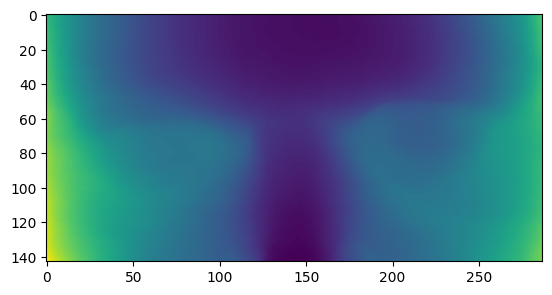

In [220]:
plt.imshow(depth_crop)

(143, 287) (143, 287, 3)


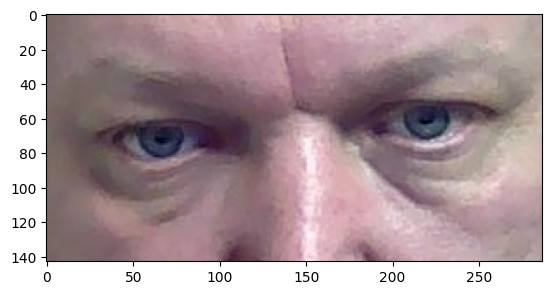

In [221]:
_ = load_image(meta)
print(depth_crop.shape, _.shape)

plt.imshow(_)
plt.show()

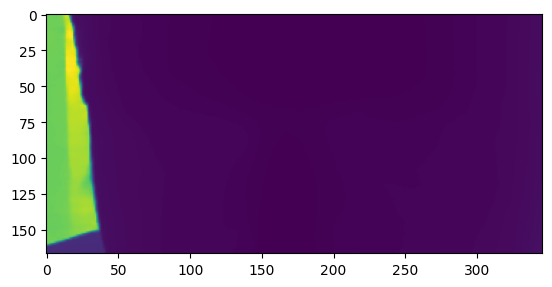

In [218]:
plt.imshow(d["depth"])

In [51]:
destination_directory = "/mnt/hdd/ai_n_slo/gazet-data-cropped"

def load_image(meta):
    '''
    Read images
    '''
    image_path = os.path.join(destination_directory, 'images', meta['task_id'], meta['step'])
    return cv2.imread(image_path)[..., ::-1]